# VibrAI — Metodología Simple (v7)

Flujo: Cargar/ventanear → EDA → Codificar → Split 70/30 → RF · XGBoost · MLP → Evaluación → Guardado.

In [1]:
"""
Módulo base de configuración y utilidades para un pipeline de
procesamiento de señales y clasificación supervisada.

Incluye:
- Importaciones de análisis (NumPy, Pandas, SciPy, Matplotlib).
- Métricas y modelos de scikit-learn (RF, MLP) y XGBoost opcional.
- Parámetros globales de datos y señal (FS, ventana, hop).
- Definición de bandas para potencias espectrales (Welch).
- Control de reproducibilidad (semilla aleatoria).
"""

import glob  # Búsqueda de archivos con patrones (e.g., *.csv, *.wav)

# --- Importaciones estándar / ciencia de datos ---
import os  # Operaciones con rutas y archivos

# --- Persistencia ---
import joblib  # Guardar/cargar modelos y pipelines en disco (.joblib)

# --- Visualización ---
import matplotlib.pyplot as plt  # Gráficas rápidas (uso general)
import numpy as np  # Cálculo numérico y arrays
import pandas as pd  # Manipulación de tablas / DataFrames

# --- Jupyter helpers ---
from IPython.display import display  # Mostrar DataFrames/figuras “bonitas” en notebooks

# --- Procesamiento de señal ---
from scipy.signal import welch  # PSD por método de Welch
from sklearn.ensemble import (
    RandomForestClassifier,  # Modelo baseline robusto para tabulares
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

# --- Scikit-learn: split, métricas, preprocesamiento y modelos ---
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier  # Perceptrón multicapa
from sklearn.pipeline import Pipeline  # Encadenar scaler + modelo en un flujo
from sklearn.preprocessing import StandardScaler  # Estandarización de features

# --- XGBoost opcional (si está instalado) ---
try:
    from xgboost import XGBClassifier  # Potente en tabulares; requiere 'xgboost'

    HAS_XGB = True
except Exception:
    HAS_XGB = False  # Si no está disponible, seguiremos con los modelos de sklearn

# --- Parámetros globales del dataset y de la señal ---
DATA_DIR = "./dataset"  # Carpeta raíz con los datos/archivos de entrada
FS = 5000  # Frecuencia de muestreo (Hz) de las señales crudas
WIN = FS  # Tamaño de ventana en muestras (aquí = 1 segundo)
HOP = WIN // 2  # Salto entre ventanas (50% de solapamiento)

MAX_PER_FILE = 120  # Máximo de ventanas a extraer por archivo (balancea clases/memoria)

# --- Extracción espectral (bandpowers vía Welch) ---
USE_WELCH_BANDS = True
# Bandas en Hz; ajusta según tu dominio (ej. vibraciones, audio, EEG, etc.)
WELCH_BANDS = [(0, 200), (200, 800), (800, 2500)]

# --- Reproducibilidad ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)  # Semilla global para resultados repetibles

In [9]:
def get_signal_cols(df, max_cols=2):
    """
    Selecciona columnas numéricas que luzcan 'señal' (no monótonas) para análisis.

    Heurística:
    - Se toman solo columnas numéricas.
    - Para cada columna, se calculan diferencias consecutivas (np.diff).
      Si casi todas las diferencias tienen el mismo signo (≈ monótona),
      se descarta (same_sign_ratio ~ 1). Si el ratio < 0.98, la consideramos no monótona.
    - Si ninguna columna cumple el criterio, se devuelven las de mayor varianza.
    - Se limita a 'max_cols' columnas.

    Parámetros
    ----------
    df : pd.DataFrame
    max_cols : int
        Número máximo de columnas a devolver.

    Retorna
    -------
    list[str]
        Nombres de columnas candidatas a señales.
    """
    num = df.select_dtypes(include=[np.number]).copy()
    if num.shape[1] == 0:
        raise ValueError("No hay columnas numéricas.")

    non_mono = []
    for c in num.columns:
        # Nota: usamos df[c] (como en tu código original) para no cambiar el comportamiento.
        s = df[c].to_numpy(float)
        d = np.diff(s)
        if len(d) == 0:
            continue
        # Proporción de difs con signo definido (ignora ceros). ~1 ⇒ monótona estricta.
        same_sign_ratio = (np.sum(d > 0) + np.sum(d < 0)) / len(d)
        if same_sign_ratio < 0.98:
            non_mono.append(c)

    # Si no encontramos no-monótonas, usamos las de mayor varianza
    if not non_mono:
        non_mono = list(num.var().sort_values(ascending=False).index[:max_cols])

    return non_mono[:max_cols]


def load_xy(path):
    """
    Carga un archivo CSV y regresa hasta 2 columnas de señal como arrays.

    Parámetros
    ----------
    path : str
        Ruta del CSV.

    Retorna
    -------
    x : np.ndarray
    y : np.ndarray | None
    cols : list[str]
        Nombres de las columnas elegidas.
    """
    df = pd.read_csv(path)
    cols = get_signal_cols(df, 2)
    x = df[cols[0]].to_numpy(float)
    y = df[cols[1]].to_numpy(float) if len(cols) > 1 else None
    return x, y, cols


def window_indices(n, win=WIN, hop=HOP):
    """
    Genera índices (inicio, fin) de ventanas deslizantes de tamaño 'win' y salto 'hop'.

    Parámetros
    ----------
    n : int
        Longitud total de la señal.
    win : int
        Tamaño de ventana (en muestras).
    hop : int
        Salto entre ventanas (en muestras).

    Retorna
    -------
    list[tuple[int, int]]
    """
    if n < win:
        return []
    return [(i, i + win) for i in range(0, n - win + 1, hop)]


def feats_time(sig):
    """
    Extrae features temporales básicos de una señal 1D.

    Retorna
    -------
    rms : float
        Valor RMS (raíz de la media de s^2).
    crest : float
        Factor de cresta = max(|s|)/RMS.
    kurt : float
        Curtosis no centrada a 'Fisher' (momento 4 normalizado).
    iqr : float
        Rango intercuartílico (P75 - P25).
    """
    s = np.asarray(sig, float)
    mu = np.mean(s)
    var = np.mean((s - mu) ** 2) + 1e-12  # varianza poblacional (+eps)
    rms = np.sqrt(var + mu**2)  # RMS = sqrt(var + mu^2)
    crest = np.max(np.abs(s)) / (rms + 1e-12)
    kurt = np.mean(((s - mu) / np.sqrt(var)) ** 4)  # momento 4 normalizado
    q75, q25 = np.percentile(s, [75, 25])
    iqr = q75 - q25
    return rms, crest, kurt, iqr


def band_powers(sig, fs=FS, bands=None):
    """
    Calcula potencias de banda relativas a partir del PSD (Welch) y el centroide espectral.

    NOTA: Implementada con np.trapezoid (NumPy ≥ 2.0), sustituyendo al deprecado np.trapz.

    Parámetros
    ----------
    sig : array-like
        Señal en el tiempo.
    fs : float
        Frecuencia de muestreo (Hz).
    bands : list[tuple[float, float]] | None
        Lista de bandas (f1, f2) en Hz. Si None, usa WELCH_BANDS.

    Retorna
    -------
    dict
        {'bp1': ..., 'bp2': ..., 'spec_centroid': ...}
        Potencias relativas por banda y centroide espectral.
    """
    if not USE_WELCH_BANDS:
        return {}

    if bands is None:
        bands = WELCH_BANDS

    # PSD mediante Welch (parámetros estándar; ajustar si hace falta resolución distinta)
    f, Pxx = welch(sig, fs=fs, nperseg=1024, noverlap=512)

    eps = 1e-12
    # Potencia total (área bajo PSD); estabilidad con eps
    total = np.trapezoid(Pxx, f) + eps

    feats = {}
    # Delimitamos bandas con searchsorted (más estable que máscaras cuando los bordes
    # no caen exactos sobre f). Aun así, tu criterio original de máscara también funcionaba.
    for i, (f1, f2) in enumerate(bands, 1):
        i1 = np.searchsorted(f, f1, side="left")
        i2 = np.searchsorted(f, f2, side="left")

        # Si hay menos de 2 puntos, no se puede integrar con trapecios
        if i2 - i1 <= 1:
            bp_rel = 0.0
        else:
            bp_rel = np.trapezoid(Pxx[i1:i2], f[i1:i2]) / total

        feats[f"bp{i}"] = float(bp_rel)

    # Centroide espectral (frecuencia media ponderada por densidad)
    feats["spec_centroid"] = float(np.trapezoid(f * Pxx, f) / total)

    return feats


def features_from_xy(x, y=None, file_name="file.csv"):
    """
    Extrae features por ventana de x (y de y si se proporciona) y devuelve un DataFrame.

    Para cada ventana:
    - Features temporales (crest, kurt, iqr, log(iqr)).
    - Potencias de banda Welch y centroide (prefijo x_ e y_).
    - Razones/diferencias entre señales cuando y ≠ None.
    - Columna 'file' con el nombre base del archivo de origen.

    Parámetros
    ----------
    x : np.ndarray
    y : np.ndarray | None
    file_name : str

    Retorna
    -------
    pd.DataFrame
        Una fila por ventana.
    """
    rows = []
    for a, b in window_indices(len(x)):
        rms_x, crest_x, kurt_x, iqr_x = feats_time(x[a:b])

        row = {
            "crest_x": crest_x,
            "kurt_x": kurt_x,
            "iqr_x": iqr_x,
            "log_iqr_x": np.log1p(iqr_x),
        }
        # Bandpowers de x (prefijo x_)
        row.update({f"x_{k}": v for k, v in band_powers(x[a:b]).items()})

        if y is not None:
            rms_y, crest_y, kurt_y, iqr_y = feats_time(y[a:b])

            # Relaciones y diferencias entre señales
            row.update(
                {
                    "crest_y": crest_y,
                    "kurt_y": kurt_y,
                    "iqr_y": iqr_y,
                    "log_iqr_y": np.log1p(iqr_y),
                    "rms_ratio_xy": rms_x / (rms_y + 1e-12),
                    "crest_ratio_xy": crest_x / (crest_y + 1e-12),
                    "kurt_diff_xy": kurt_x - kurt_y,
                    "iqr_ratio_xy": (iqr_x + 1e-12) / (iqr_y + 1e-12),
                }
            )
            # Bandpowers de y (prefijo y_)
            row.update({f"y_{k}": v for k, v in band_powers(y[a:b]).items()})

        row["file"] = os.path.basename(file_name)
        rows.append(row)

    return pd.DataFrame(rows)


def label_from_name(path):
    """
    Etiqueta binaria basada en el nombre del archivo.
    - 'normal' si el nombre contiene 'no_fault' (insensible a mayúsculas/minúsculas).
    - 'fault' en caso contrario.
    """
    return "normal" if ("no_fault" in os.path.basename(path).lower()) else "fault"

In [11]:
# --- Carga y extracción de features ---

# 1) Recolecta rutas de todos los CSV en DATA_DIR
paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
if not paths:
    # Corta la ejecución si no hay archivos; evita fallos posteriores.
    raise SystemExit(f"No se hallaron CSV en {DATA_DIR!r}")

frames = []
for p in paths:
    # 2) Lee hasta 2 columnas de señal (get_signal_cols) y las devuelve como arrays
    x, y, cols = load_xy(p)

    # 3) Extrae features por ventanas de 'x' (y también de 'y' si existe)
    #    Incluye: temporales, bandpowers Welch, relaciones x–y y 'file'
    F = features_from_xy(x, y, p)

    # 4) Etiqueta el archivo a partir de su nombre ('no_fault' -> normal, else fault)
    F["label"] = label_from_name(p)

    frames.append(F)

# 5) Concatena todas las ventanas de todos los archivos en un único DataFrame
df = pd.concat(frames, ignore_index=True)

# 6) Balanceo por archivo: limita a 'MAX_PER_FILE' ventanas por cada archivo
#    (si hay menos, toma todas). Esto controla memoria y reduce sesgo por archivo.
df = (
    df.groupby("file", group_keys=False)
    .apply(
        lambda g: g.sample(min(len(g), MAX_PER_FILE), random_state=RANDOM_STATE),
        include_groups=False,  # <- quita el warning
    )
    .reset_index(drop=True)
)

# 7) Inspección rápida: primeras filas y conteo de clases
display(df.head())
print(df["label"].value_counts())

# 8) Selección de columnas de features (excluye la etiqueta y el nombre de archivo)
feat_cols_all = [c for c in df.columns if c not in ["label", "file"]]

,crest_x,kurt_x,iqr_x,log_iqr_x,x_bp1,x_bp2,x_bp3,x_spec_centroid,crest_y,kurt_y,...,log_iqr_y,rms_ratio_xy,crest_ratio_xy,kurt_diff_xy,iqr_ratio_xy,y_bp1,y_bp2,y_bp3,y_spec_centroid,label
0,1.002036,3.424681,0.001478,0.001477,0.146849,0.200799,0.645887,1051.296285,1.001699,3.190403,...,0.001313,1.037287,1.000337,0.234278,1.125003,0.120492,0.231203,0.642142,1119.463683,fault
1,1.001485,2.967551,0.001314,0.001313,0.133014,0.196079,0.669155,1070.454281,1.001321,3.022118,...,0.001313,1.037277,1.000164,-0.054567,1.000003,0.099986,0.250838,0.645054,1125.333120,fault
2,1.010197,3.190291,0.008870,0.008831,0.012341,0.198232,0.785506,1491.287302,1.009830,3.125996,...,0.008668,1.037732,1.000363,0.064295,1.018871,0.025565,0.332517,0.628621,1284.264959,fault
3,1.002153,3.069050,0.001971,0.001969,0.070712,0.330335,0.594223,1118.148293,1.002215,3.060488,...,0.001969,1.037261,0.999938,0.008562,1.000003,0.063557,0.409334,0.521819,1049.837110,fault
4,1.007754,3.120698,0.007720,0.007690,0.065491,0.254830,0.674730,1243.932146,1.009705,3.111801,...,0.008179,1.037488,0.998067,0.008897,0.940003,0.098757,0.314821,0.580528,1116.409844,fault


label
fault     295
normal     59
Name: count, dtype: int64


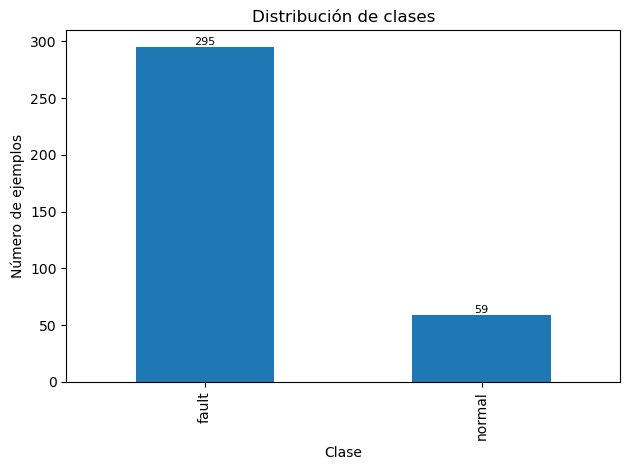

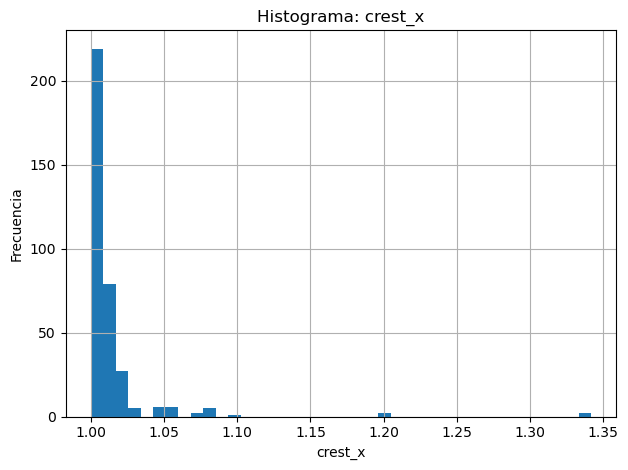

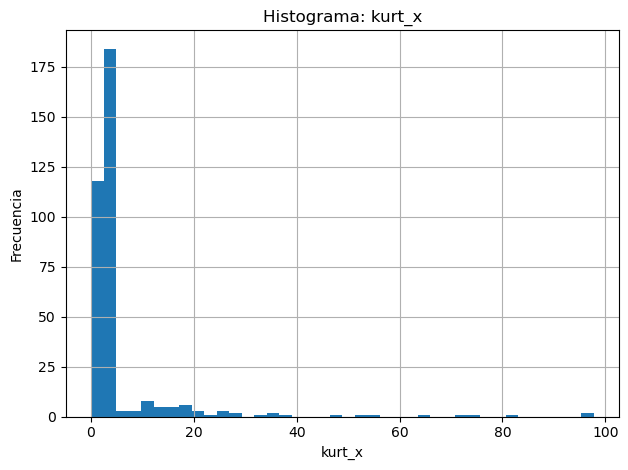

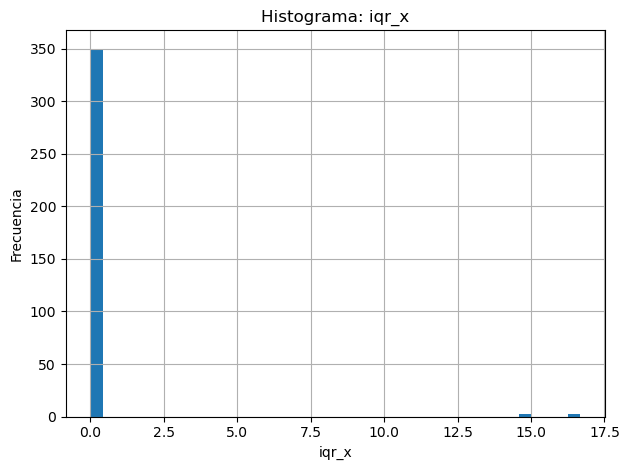

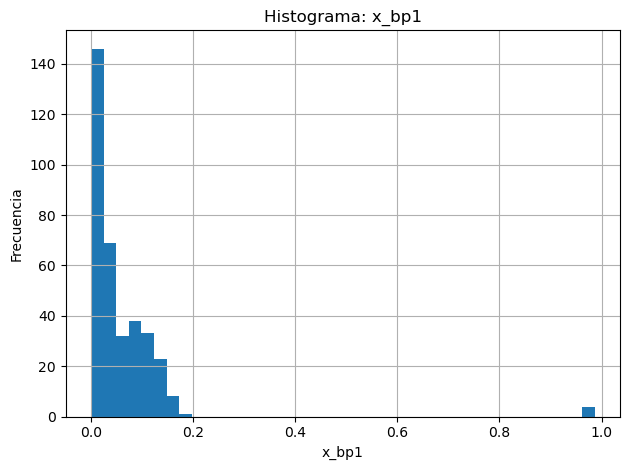

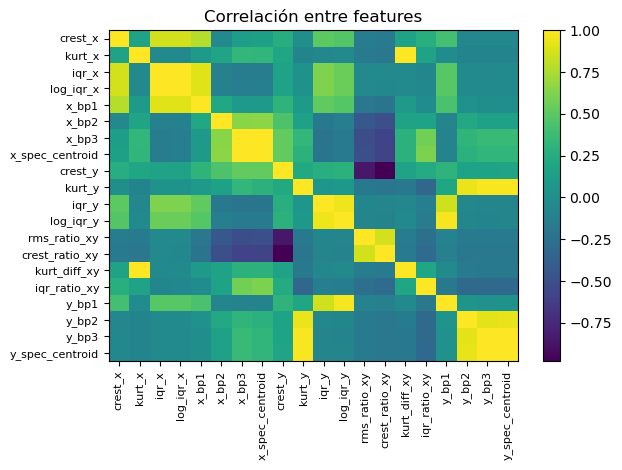

In [16]:
# --- EDA básica: distribución de clases, histogramas y correlación ---

# 1) Distribución de clases
ax = df["label"].value_counts().plot(kind="bar")
ax.set_title("Distribución de clases")
ax.set_xlabel("Clase")
ax.set_ylabel("Número de ejemplos")
# Conteos encima de cada barra (útil para revisar balanceo)
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=8,
    )
plt.tight_layout()
plt.show()

# 2) Histogramas de algunas features clave
#    Tomamos hasta 4 columnas que comiencen con crest_, kurt_, iqr_, x_bp, y_bp
cols_to_plot = [
    c for c in df.columns if c.startswith(("crest_", "kurt_", "iqr_", "x_bp", "y_bp"))
][:4]

for c in cols_to_plot:
    plt.figure()
    df[c].hist(bins=40)  # Histograma simple (pandas + matplotlib)
    plt.title(f"Histograma: {c}")
    plt.xlabel(c)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# 3) Matriz de correlación entre features numéricas
#    Usamos select_dtypes para evitar warnings si hay columnas no numéricas.
corr_df = df[feat_cols_all].select_dtypes(include=[np.number]).corr().fillna(0.0)

plt.figure()
plt.imshow(corr_df.to_numpy(), aspect="auto")
plt.title("Correlación entre features")
plt.colorbar()
# Etiquetas (pueden ser muchas; ajusta fontsize si se saturan)
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr_df.index)), corr_df.index, fontsize=8)
plt.tight_layout()
plt.show()

In [17]:
# --- Codificación de etiquetas y split estratificado ---

# Mapas de etiqueta ↔ entero (útil para reportes y para invertir predicciones si hace falta)
label_to_int = {"normal": 0, "fault": 1}
int_to_label = np.array(["normal", "fault"], dtype=object)

# y: vector de clases como enteros (0/1)
y = df["label"].map(label_to_int).astype(int)

# X: solo columnas de features (ya definidas en feat_cols_all)
#    Forzamos numéricas por seguridad (evita problemas si se coló algo no numérico).
X = df[feat_cols_all].select_dtypes(include=[np.number]).copy()

# (Opcional) Saneamiento rápido si hubiera NaN/Inf por algún preprocesado:
# X.replace([np.inf, -np.inf], np.nan, inplace=True)
# X.fillna(X.median(), inplace=True)

# Split estratificado para conservar la proporción de clases en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE,
)

print("Tamaños:", X_train.shape, X_test.shape)

# Chequeo rápido de balanceo post-split (conteo por clase)
# np.bincount asume clases 0..K-1; perfecto para nuestro caso 0/1
print("Distribución train (normal, fault):", np.bincount(y_train))
print("Distribución test  (normal, fault):", np.bincount(y_test))


Tamaños: (283, 20) (71, 20)
Distribución train (normal, fault): [ 47 236]
Distribución test  (normal, fault): [12 59]


In [18]:
# --- Entrenamiento de modelos: RF, XGBoost (opcional) y MLP ---
reports = {}  # almacenará: nombre_modelo -> (y_pred_test, modelo_entrenado)

# 1) Random Forest
#    - n_estimators: número de árboles (600 da buen sesgo/varianza).
#    - max_features="sqrt": regla típica para clasificación (raíz de #features por split).
#    - min_samples_leaf=3: evita hojas con muy pocos ejemplos (reduce sobreajuste).
#    - class_weight="balanced_subsample": pondera clases según su frecuencia en cada bootstrap.
#    - n_jobs=-1: usa todos los núcleos disponibles (más rápido).
rf = RandomForestClassifier(
    n_estimators=600,
    max_features="sqrt",
    min_samples_leaf=3,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
rf.fit(X_train, y_train)
reports["RandomForest"] = (rf.predict(X_test), rf)

# 2) XGBoost (solo si está instalado)
#    - scale_pos_weight: corrige desbalance aproximando w_neg/w_pos.
#    - tree_method="hist": más rápido y con menor memoria.
#    - eval_metric="logloss": evita el label encoder deprecado y define métrica explícita.
if HAS_XGB:
    n_pos = int((y_train == 1).sum())
    n_neg = int((y_train == 0).sum())
    spw = n_neg / max(n_pos, 1)  # razón negativas/positivas (evita div/0)

    xgb = XGBClassifier(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=2.0,
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        scale_pos_weight=spw,
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )
    xgb.fit(X_train, y_train)
    reports["XGBoost"] = (xgb.predict(X_test), xgb)

# 3) MLP (Perceptrón Multicapa) en Pipeline con StandardScaler
#    - Estandarizar es crucial para redes (mejora convergencia).
#    - early_stopping=True: reserva automáticamente un 10% de train para validación
#      y detiene si no mejora durante 'n_iter_no_change' épocas.
mlp = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "clf",
            MLPClassifier(
                hidden_layer_sizes=(64, 32),
                activation="relu",
                max_iter=300,
                early_stopping=True,
                n_iter_no_change=15,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)
mlp.fit(X_train, y_train)
reports["MLP"] = (mlp.predict(X_test), mlp)

print("Modelos entrenados:", list(reports.keys()))


Modelos entrenados: ['RandomForest', 'XGBoost', 'MLP']



=== RandomForest ===
              precision    recall  f1-score   support

      normal     1.0000    1.0000    1.0000        12
       fault     1.0000    1.0000    1.0000        59

    accuracy                         1.0000        71
   macro avg     1.0000    1.0000    1.0000        71
weighted avg     1.0000    1.0000    1.0000        71

Matriz (orden normal, fault):
 [[12  0]
 [ 0 59]]


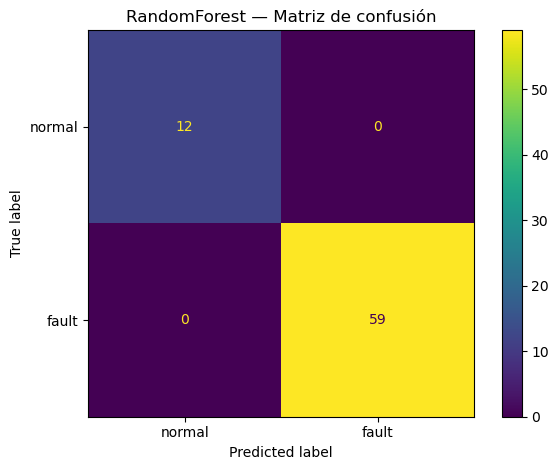

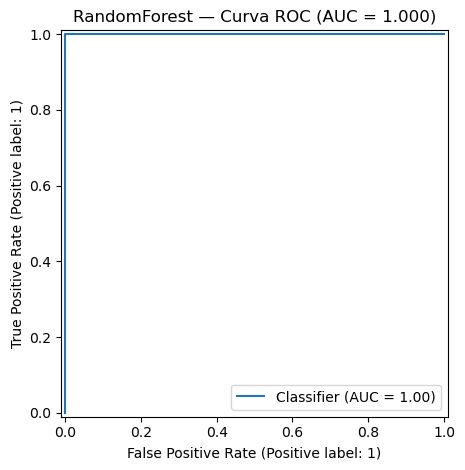


=== XGBoost ===
              precision    recall  f1-score   support

      normal     0.8462    0.9167    0.8800        12
       fault     0.9828    0.9661    0.9744        59

    accuracy                         0.9577        71
   macro avg     0.9145    0.9414    0.9272        71
weighted avg     0.9597    0.9577    0.9584        71

Matriz (orden normal, fault):
 [[11  1]
 [ 2 57]]


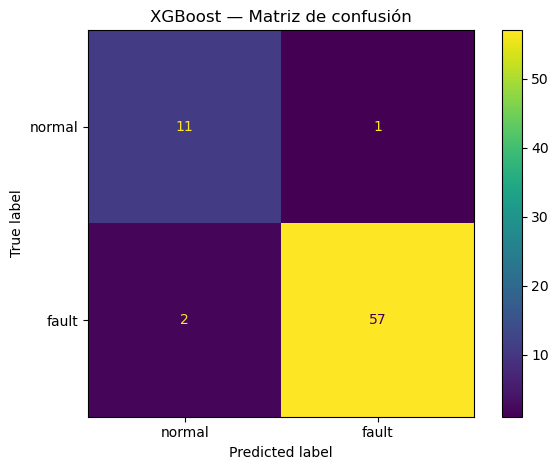

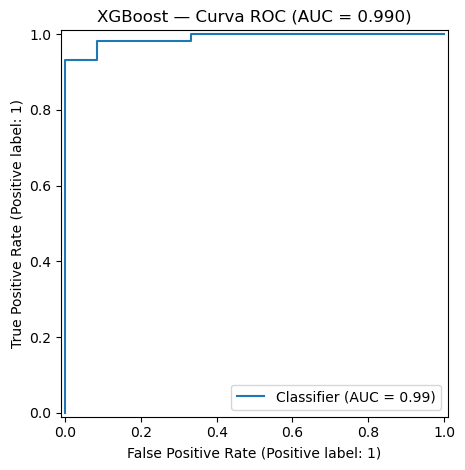


=== MLP ===
              precision    recall  f1-score   support

      normal     0.0000    0.0000    0.0000        12
       fault     0.8310    1.0000    0.9077        59

    accuracy                         0.8310        71
   macro avg     0.4155    0.5000    0.4538        71
weighted avg     0.6905    0.8310    0.7543        71

Matriz (orden normal, fault):
 [[ 0 12]
 [ 0 59]]


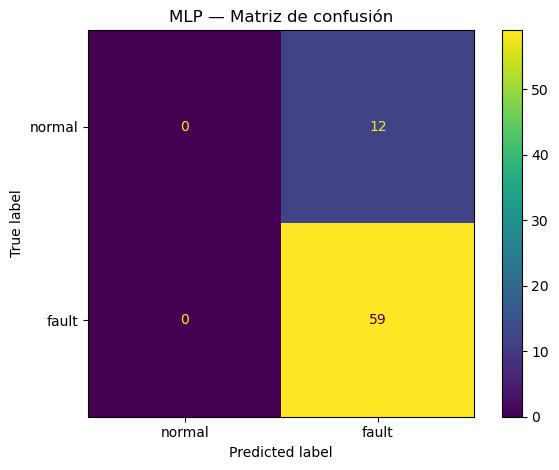

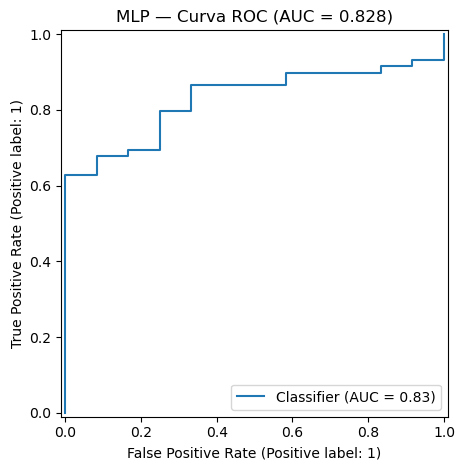

,model,accuracy,roc_auc
0,RandomForest,1.000000,1.000000
1,XGBoost,0.957746,0.990113
2,MLP,0.830986,0.827684


In [19]:
# --- Evaluación por modelo: reporte, matriz de confusión y ROC-AUC (si hay proba) ---
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay
)

summary = []  # para resumir accuracy/AUC por modelo

for name, (y_hat, model) in reports.items():
    print(f"\n=== {name} ===")

    # Reporte por clase (evita warnings cuando una clase no aparece en y_hat)
    print(classification_report(
        y_test, y_hat,
        target_names=["normal", "fault"],
        digits=4,
        zero_division=0
    ))

    # Matriz de confusión (en el orden 0→normal, 1→fault)
    cm = confusion_matrix(y_test, y_hat, labels=[0, 1])
    print("Matriz (orden normal, fault):\n", cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["normal", "fault"])
    disp.plot(values_format="d")
    plt.title(f"{name} — Matriz de confusión")
    plt.tight_layout()
    plt.show()

    # ROC-AUC si el modelo expone puntajes (probabilidades o función de decisión)
    y_score = None
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)

    acc = (y_hat == y_test).mean()
    if y_score is not None and len(np.unique(y_test)) == 2:
        auc = roc_auc_score(y_test, y_score)
        RocCurveDisplay.from_predictions(y_test, y_score)
        plt.title(f"{name} — Curva ROC (AUC = {auc:.3f})")
        plt.tight_layout()
        plt.show()
    else:
        auc = np.nan  # no disponible

    summary.append({"model": name, "accuracy": acc, "roc_auc": auc})

# Resumen rápido ordenado por AUC (si no hubo AUC, caerá en NaN)
summary_df = pd.DataFrame(summary).sort_values(
    by=["roc_auc", "accuracy"], ascending=[False, False]
)
display(summary_df)


In [20]:
# --- Guardado de artefactos (modelos + columnas de features) ---

import json  # para guardar el mapeo de etiquetas

os.makedirs("artefactos_v7", exist_ok=True)

for k, (yhat, model) in reports.items():
    # Guarda cada modelo entrenado en formato .joblib
    # Sugerencia: compress=3 reduce tamaño sin afectar el uso posterior.
    joblib.dump(model, f"artefactos_v7/model_{k.lower()}_v7.joblib", compress=3)

# Guarda el listado de columnas de features usadas en entrenamiento
pd.Series(feat_cols_all).to_csv("artefactos_v7/feature_columns_v7.csv", index=False)

# (Opcional pero recomendado) Guarda el mapeo de etiquetas para reproducibilidad
label_mapping = {
    "label_to_int": label_to_int,
    "int_to_label": list(int_to_label),
}
with open("artefactos_v7/labels_v7.json", "w", encoding="utf-8") as f:
    json.dump(label_mapping, f, ensure_ascii=False, indent=2)

print("Artefactos guardados en 'artefactos_v7/'.")


Artefactos guardados en 'artefactos_v7/'.
